In [1]:
library(rhdf5)
library(MASS)
library(BoutrosLab.plotting.general)

Loading required package: lattice

Loading required package: latticeExtra

Loading required package: cluster

Loading required package: hexbin

Loading required package: grid


Attaching package: ‘BoutrosLab.plotting.general’


The following object is masked from ‘package:stats’:

    dist




# Test reading h5 and accessing data

In [2]:
fh <- "/iblm/netapp/home/karthik/crisprQTL/simulated_data/sim.h5"

Get internal structure of h5 file

In [3]:
h5ls(fh)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_DATASET,INTEGER,13000 x 50000
2,/,guides,H5I_GROUP,,
3,/guides,metadata,H5I_DATASET,COMPOUND,2000
4,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 2000
5,/,linear_predictor,H5I_DATASET,FLOAT,13000 x 50000
6,/,mu,H5I_DATASET,FLOAT,13000 x 50000
7,/,scaling_factors,H5I_DATASET,FLOAT,50000
8,/,x,H5I_GROUP,,


# Load fixed values

Coefficients (ground truth for evaluating model performance) 

Cell cycle scores (same for every gene)

In [5]:
coeffs <- h5read(file = fh, name = "coeffs")
cell.cycle.scores <- h5read(fh, "x/cell_cycle_scores")
scaling.factors <- h5read(file = fh, name = "scaling_factors")
guides.metadata <- h5read(file = fh, name = "guides/metadata")

In [6]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,3683,0.7247283,-4.462767
2,1175,0.6302226,-4.838250
3,11331,0.5332885,-2.852283
4,1399,0.6552179,-2.778439
5,543,0.6759810,-3.910947
6,10902,0.5953462,-2.812525


# Define null and alternative models

## Model
$$y = \text{NB}(\mu=s \cdot \exp \left( \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 \right), n=\sigma)$$
### $H_0: \beta_1 = 0 $
### $H_A: \beta_1 \neq 0 $



### Test for one gene with `glm.nb` (MASS library)

In [7]:
test.gene <- 3683

obs.counts <- h5read(file = fh, name = "counts", index = list(test.gene, 1:50000))
gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factor = scaling.factors)

In [8]:
head(gene.data)

,guide.eff,s.score,g2m.score,counts,scaling.factor
,<int>,<dbl>,<dbl>,<int>,<dbl>
1,0,-1.0309103,1.1526160,0,0.050330
2,0,-0.4639413,1.2934445,1,0.050077
3,0,0.5149060,-0.4730435,0,0.049864
4,0,-0.9497266,0.3118649,0,0.050117
5,0,1.2838343,-2.2465534,0,0.050016
6,0,-0.7403177,0.4665516,0,0.049508


In [9]:
unique(gene.data$guide.eff)

[1] 0 1

In [10]:
ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factor)), data = gene.data)

In [11]:
summary(ml)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factor)), 
    data = gene.data, init.theta = 1.513933735, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8242  -0.5363  -0.1985  -0.0394   4.1341  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.85635    0.01464   58.49   <2e-16 ***
guide.eff   -4.16329    0.27430  -15.18   <2e-16 ***
s.score      5.30530    0.01828  290.18   <2e-16 ***
g2m.score    3.21472    0.01469  218.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5139) family taken to be 1)

    Null deviance: 493207  on 49999  degrees of freedom
Residual deviance:  27100  on 49996  degrees of freedom
AIC: 105755

Number of Fisher Scoring iterations: 1


              Theta:  1.5139 
          Std. Err.:  0.0237 

 2 x log-likelihood:  -105744.9340 

In [12]:
coeffs[test.gene,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3683,0.780297,-4.462767,5.321519,3.227325,1.829826


# Test for all target genes

E.g. the 1000 genes in our simulated data whose enhancers are targeted by gRNAs in our library 

In [28]:
ml.list <- list()

for (gene in guides.metadata$target.gene[1:3]) {
    print(gene)
    obs.counts <- h5read(file = fh, name = "counts", index = list(gene, 1:50000))
    gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factors = scaling.factors)
    ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score, data = gene.data)
    ml.list[[gene]] <- ml
}

[1] 3683
[1] 1175
[1] 11331


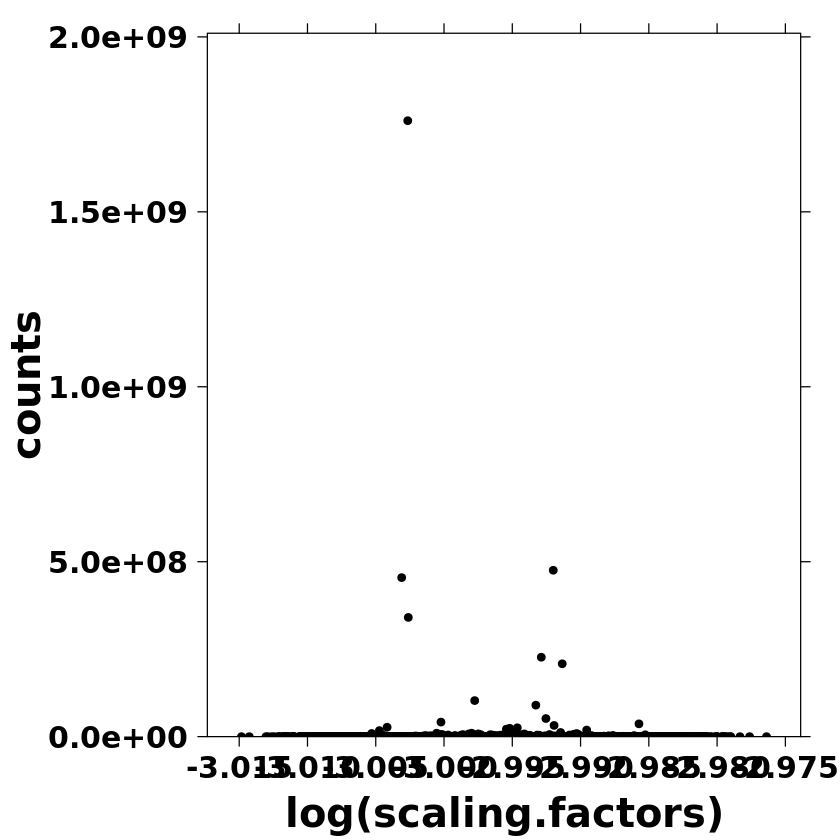

In [29]:
create.scatterplot(
    formula = counts ~ log(scaling.factors),
    data = gene.data
)

In [32]:
cor.test(log(gene.data$scaling.factors), gene.data$counts, method = 'spearman')

Warning message in cor.test.default(log(gene.data$scaling.factors), gene.data$counts, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  log(gene.data$scaling.factors) and gene.data$counts
S = 2.0774e+13, p-value = 0.525
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
0.002842585 


In [14]:
summary(ml.list[[1175]])


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factors)), 
    data = gene.data, init.theta = 1.517836905, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7483  -0.7233  -0.3835  -0.0663   4.2255  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.82181    0.01076 169.385  < 2e-16 ***
guide.eff   -5.19567    0.71304  -7.287 3.18e-13 ***
s.score      3.05735    0.01492 204.953  < 2e-16 ***
g2m.score    2.33210    0.01370 170.213  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5178) family taken to be 1)

    Null deviance: 131409  on 49999  degrees of freedom
Residual deviance:  34801  on 49996  degrees of freedom
AIC: 99823

Number of Fisher Scoring iterations: 1


              Theta:  1.5178 
          Std. Err.:  0.0280 

 2 x log-likelihood:  -99813.2890 

In [15]:
coeffs[1175,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1175,1.766874,-4.83825,3.061181,2.336816,1.22111
